# Product Usage Analysis
I conducted the data analytics project turing my time at a Finnish IOT logisstics startup. The main objective of the project was to provide an overview of data capabilities and how users are using the product.

Note: datasets used are not publicly available. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
import datetime
import re
import ast
import itertools

# Data

## Sensor Code

In [24]:
pd.DataFrame({'sensor': [0,3,4,5,7], 'metric': ['temperature (C)','shock (g)','humidity (%)'\
                                                , 'ambient light (scale)',\
                                                'external temperature sensor (C)']})

,sensor,metric
0,0,temperature (C)
1,3,shock (g)
2,4,humidity (%)
3,5,ambient light (scale)
4,7,external temperature sensor (C)


## Loggers

In [7]:
loggers = pd.read_csv('../Datasets/loggers.csv') 
loggers = loggers.loc[loggers['serial'] != 310072]
loggers = loggers.loc[loggers['serial'] != 200078]

## Measurements

In [12]:
measurements = pd.read_csv('Datasets/measurements.csv')

## Scan Events

In [10]:
scanevents = pd.read_csv('../Datasets/scan_events.csv')

In [6]:
scanevents['new_data'].max()

23557.0

## Teams

In [12]:
teams = pd.read_csv('../Datasets/teams.csv')

In [13]:
teams.loc[teams['team_name'] == 'Neveres dosis', 'team_name'] = 'Gepork'

## Users

In [107]:
users = pd.read_csv('Datasets/users.csv')

## Alert Rules

In [871]:
alertrules = pd.read_csv('Datasets/alert_rules.csv')

## Alert Hits

In [271]:
alerthits = pd.read_csv('Datasets/alert_hits.csv')

## Missions

In [4]:
missions = pd.read_csv('../Datasets/missions.csv')
missions['starts_at'] = pd.to_datetime(missions['starts_at'])
missions['ends_at'] = pd.to_datetime(missions['ends_at'])

In [5]:
# Deleting Test team and Test team 2
missions = missions.loc[missions['logger_id'] != 'ObjectId(5ce267cfb6861a003076acc4)']
missions = missions.loc[missions['logger_id'] != 'ObjectId(5cdc1b668fcb36002dc54f56)']

In [6]:
missions['mission_duration_in_hours'] = missions['mission_duration_in_secs'] / 3600.0

## Loggers x Measurements

In [446]:
loggers_measurements = loggers.merge(measurements, how = 'inner', left_on = '_id', right_on = 'logger_id')\
.drop(columns = ['_id_y', 'logger_id']).rename(columns = {'_id_x':'logger_id'})

## Loggers x Scan Events

In [447]:
loggers_scanevents = loggers.merge(scanevents, how = 'inner',\
                    left_on = '_id', right_on = 'logger_id')

In [448]:
loggers_scanevents = loggers_scanevents.drop(columns = 'logger_id')\
.rename(columns = {'_id_x':'logger_id', '_id_y':'scan_id'})

In [449]:
loggers_scanevents['created_at'] = pd.to_datetime(loggers_scanevents['created_at'])
loggers_scanevents = loggers_scanevents.sort_values(by = ['created_at'])

## Loggers x Teams

In [7]:
loggers_teams = loggers.merge(teams, how = 'inner', left_on = 'owner_id', right_on = '_id')
loggers_teams = loggers_teams.rename(columns = {'_id_x':'logger_id', '_id_y':'team_id'})

### Loggers x Teams x Measurements

In [974]:
loggers_teams_measurements = loggers_measurements.merge(teams, how = 'inner', left_on = 'owner_id', right_on = '_id')

In [975]:
loggers_teams_measurements = loggers_teams_measurements.drop(columns = ['_id'])

## Loggers x Teams x Scan Events

In [11]:
loggers_teams_scanevents = loggers_teams.merge(scanevents, how = 'inner', on = 'logger_id').drop(columns = ['owner_id', 'created_at_x', '_id'])\
                            .rename(columns = {'created_at_y':'scanned_at'})
loggers_teams_scanevents['scanned_at'] = pd.to_datetime(loggers_teams_scanevents['scanned_at'])


## Loggers x Missions

In [8]:
loggers_missions = loggers.merge(missions, how = 'inner', left_on = '_id', right_on = 'logger_id')

In [9]:
loggers_missions = loggers_missions.drop(columns = 'logger_id').rename(columns = {'_id':'logger_id', 'name':'mission_name'})

In [10]:
loggers_missions = loggers_missions.loc[(loggers_missions['mission_duration_in_hours'] > 0.16) & (loggers_missions['mission_duration_in_hours'] < 8670)]

## Loggers x Missions x Teams

In [14]:
loggers_missions_teams = loggers_missions.merge(teams, how = 'inner', left_on = 'owner_id', right_on = '_id')\
.drop(columns = ['_id', 'created_at_y', 'permissions_y', 'permissions_x']).rename(columns = {'created_at_x':'mission_created_at'\
                                                                                , 'name':'mission_name'})

In [22]:
len(loggers_missions.loc[loggers_missions['owner_id'] == 'ObjectId(5bb30fbf2669ca1a890025ac)']['mission_id'].unique())
#_teams.loc[loggers_missions_teams['team_name'] == 'MagnumMedical']

142

## Loggers x Alert Hits

In [452]:
loggers_alerthits = loggers.merge(alerthits, how = 'inner', left_on = '_id', right_on = 'logger_id')

In [453]:
loggers_alerthits = loggers_alerthits.drop(columns = ['_id_y', 'logger_id',]).rename(columns = {'_id_x':'logger_id'})

In [454]:
loggers_alerthits['ts'] = pd.to_datetime(loggers_alerthits['ts'])

In [455]:
loggers_alerthits = loggers_alerthits.sort_values(by = 'ts')

## Loggers x Alert Hits x Alert Rules

In [924]:
loggers_alerthits_alertrules = loggers_alerthits.merge(alertrules, how = 'left', left_on = 'rule_id', right_on = '_id')

In [925]:
loggers_alerthits_alertrules = loggers_alerthits_alertrules.drop(columns = ['_id', 'sensor_y']).rename(columns = {'sensor_x':'sensor'})

# Analysis

# Measurements

### Count of Measurements by Sensor

In [456]:
measurements_count = loggers_measurements['sensor'].value_counts()\
                    .to_frame().rename(columns={'sensor':'count'})

In [457]:
measurements_count.index = ['temperature (C)', 'ambient light (scale)', 'humidity (%)', 'shock (g)']

In [650]:
measurements_count

,count,mean,min,max,std
temperature (C),15862535,14.317138,-30.0,80.000000,8.516959
ambient light (scale),2145299,67.939571,0.0,15000.000000,653.375233
humidity (%),1470670,38.561184,1.0,100.000000,18.257025
shock (g),6574,7.934549,0.9,27.655198,5.320642


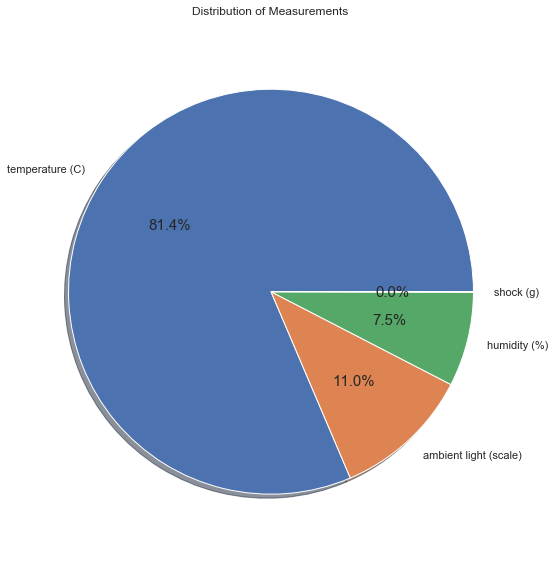

In [970]:
fig1, ax1 = plt.subplots()
ax1.pie(measurements_count['count'].to_list(), labels=measurements_count.index.to_list(), autopct='%1.1f%%', shadow=True)
ax1.axis('equal')
ax1.set(title="Distribution of Measurements")
plt.rcParams['font.size'] = 15
plt.show()

### Count of Measurements by Logger

In [655]:
measurements_count_by_logger = loggers_measurements['logger_id'].value_counts()

In [949]:
measurements_count_by_logger.describe()

count      2100.000000
mean       9278.608571
std       18186.543472
min           1.000000
25%         396.250000
50%        2547.500000
75%        9668.000000
max      177660.000000
Name: logger_id, dtype: float64

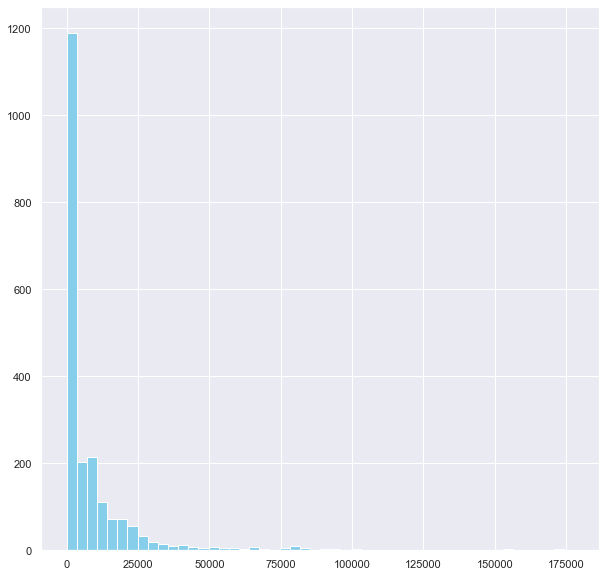

In [950]:
fig, ax = plt.subplots(figsize=(10,10))
ax.hist(measurements_count_by_logger, bins=50, color="skyblue");

### Count of Measurements by Team

In [978]:
measurements_by_team = loggers_teams_measurements['team_name'].value_counts()

In [979]:
measurements_by_team.head(10)

Fazer Leipomot Oy                     3395435
Gepork                                2031826
Budbee                                 952107
Loggs Oy                               921167
Suomen Talotekniikka Jyväskylä         787337
Helsinginktk                           323527
ABB Oy Distribution Solution Vaasa     296254
ABB Drives                             279472
Kesko Oyj                              261546
Bmlv WSM                               261512
Name: team_name, dtype: int64

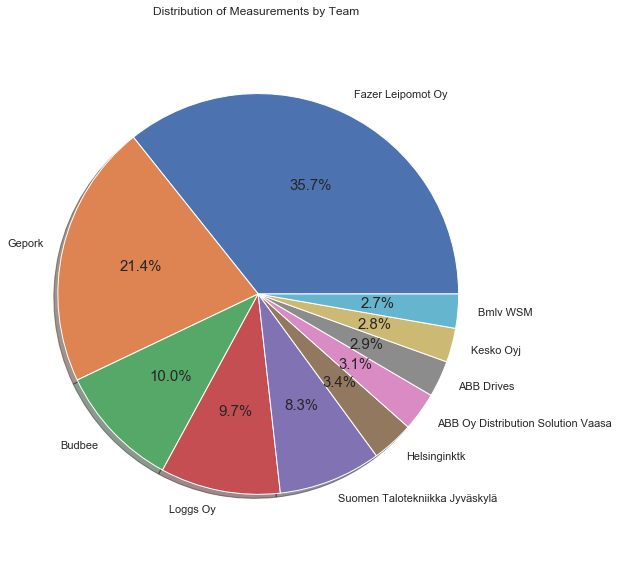

In [980]:
fig1, ax1 = plt.subplots()
ax1.pie(measurements_by_team.head(10).to_list(), labels=measurements_by_team.head(10).index.to_list(), autopct='%1.1f%%', shadow=True)
ax1.axis('equal')
ax1.set(title="Distribution of Measurements by Team")
plt.show()

### Count of Measurements by Month

In [35]:
def month(date):
    return date[0:7]

In [487]:
measurements_date = loggers_measurements['ts'].apply(month)

In [488]:
measurements_days = pd.to_datetime(loggers_measurements['ts']).dt.strftime('%Y-%m')

In [489]:
measurements_months = measurements_days.value_counts()

In [490]:
measurements_by_month = measurements_months\
                        .to_frame().rename(columns = {'ts':'measurements'})

In [491]:
measurements_by_month['month'] = measurements_by_month.index

In [492]:
measurements_by_month = measurements_by_month.sort_values(by = ['month'])

In [493]:
measurements_by_month.sort_values(by = 'measurements', ascending = False)

,measurements,month
2020-02,2598294,2020-02
2020-01,2408488,2020-01
2020-03,2393986,2020-03
2019-12,2234171,2019-12
2019-11,1928769,2019-11
2019-10,1914181,2019-10
2020-05,1837720,2020-05
2019-09,1437661,2019-09
2020-04,1237942,2020-04
2019-08,963321,2019-08


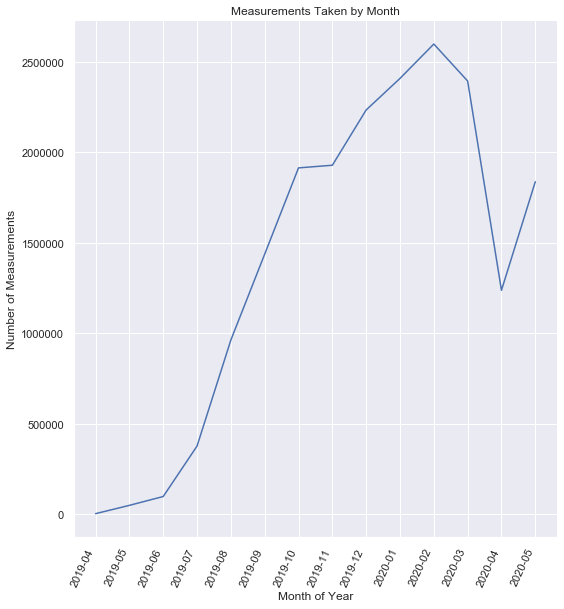

In [813]:
months_graph = sns.relplot(x = 'month', y = "measurements", kind = 'line', data = measurements_by_month, height=8)

for axes in months_graph.axes.flat:
    axes.set_xticklabels(axes.get_xticklabels(), rotation=65, horizontalalignment='right')

plt.title('Measurements Taken by Month')
months_graph.set(xlabel='Month of Year', ylabel='Number of Measurements')

## General Measurements Statistics

### Temperature

In [494]:
temp_stats = loggers_measurements.loc[loggers_measurements['sensor'] == 0]['val']

In [495]:
temp_stats.describe() 

count    1.586254e+07
mean     1.431714e+01
std      8.516959e+00
min     -3.000000e+01
25%      6.400000e+00
50%      1.720000e+01
75%      2.080000e+01
max      8.000000e+01
Name: val, dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x1f063026a0>,
 'caps': [<matplotlib.lines.Line2D at 0x1e87862d30>,
 'boxes': [<matplotlib.lines.Line2D at 0x1e87862198>],
 'medians': [<matplotlib.lines.Line2D at 0x1e8786d470>],
 'fliers': [<matplotlib.lines.Line2D at 0x1e8786d7f0>],
 'means': []}

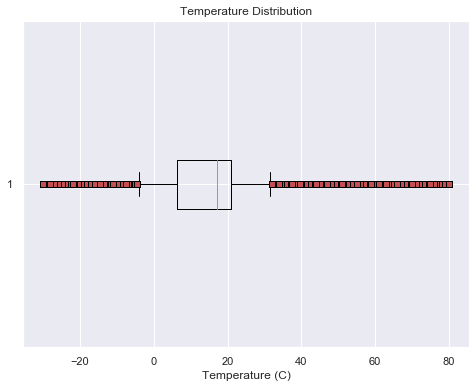

In [695]:
red_square = dict(markerfacecolor='r', marker='s')
fig1, ax1 = plt.subplots()
fig1.set_size_inches(8, 6, forward=True)
ax1.set_title('Temperature Distribution')
ax1.set_xlabel('Temperature (C)')
ax1.boxplot(temp_stats, flierprops=red_square, vert=False, whis=0.75)

### Shock

In [496]:
shock_stats = loggers_measurements.loc[loggers_measurements['sensor'] == 3]['val']

In [497]:
shock_stats.describe()

count    6574.000000
mean        7.934549
std         5.320642
min         0.900000
25%         3.721559
50%         6.590903
75%        10.036309
max        27.655198
Name: val, dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x1f0a8cd160>,
 'caps': [<matplotlib.lines.Line2D at 0x1f0a8ed7f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1f0a8ddc18>],
 'medians': [<matplotlib.lines.Line2D at 0x1f0a8edef0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1f0a8ede80>],
 'means': []}

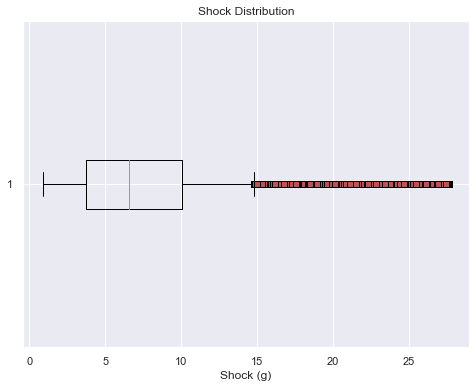

In [697]:
fig1, ax1 = plt.subplots()
fig1.set_size_inches(8, 6, forward=True)
ax1.set_title('Shock Distribution')
ax1.set_xlabel('Shock (g)')
ax1.boxplot(shock_stats, flierprops=red_square, vert=False, whis=0.75)

### Humidity

In [498]:
humidity_stats = loggers_measurements.loc[loggers_measurements['sensor'] == 4]['val']

In [499]:
humidity_stats.describe()

count    1.470670e+06
mean     3.856118e+01
std      1.825702e+01
min      1.000000e+00
25%      2.500000e+01
50%      3.700000e+01
75%      4.900000e+01
max      1.000000e+02
Name: val, dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x1f080988d0>,
 'caps': [<matplotlib.lines.Line2D at 0x1f9a92d630>,
 'boxes': [<matplotlib.lines.Line2D at 0x1f0a942a58>],
 'medians': [<matplotlib.lines.Line2D at 0x1f9a92dd30>],
 'fliers': [<matplotlib.lines.Line2D at 0x1f9a92de48>],
 'means': []}

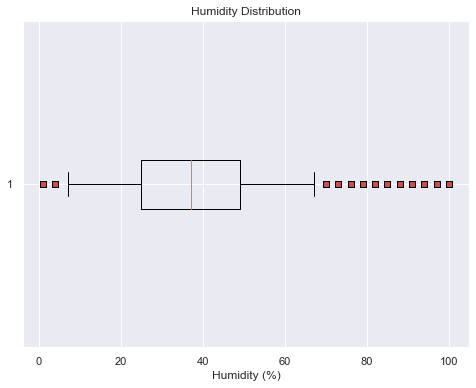

In [698]:
fig1, ax1 = plt.subplots()
fig1.set_size_inches(8, 6, forward=True)
ax1.set_title('Humidity Distribution')
ax1.set_xlabel('Humidity (%)')
ax1.boxplot(humidity_stats, flierprops=red_square, vert=False, whis=0.75)

### Light

In [500]:
light_stats = loggers_measurements.loc[loggers_measurements['sensor'] == 5]['val']

In [501]:
light_stats.describe()

count    2.145299e+06
mean     6.793957e+01
std      6.533752e+02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      1.500000e+04
Name: val, dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x1f9a96d048>,
 'caps': [<matplotlib.lines.Line2D at 0x1f9a98c4e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1f9a97e908>],
 'medians': [<matplotlib.lines.Line2D at 0x1f9a98cbe0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1f9a98cf60>],
 'means': []}

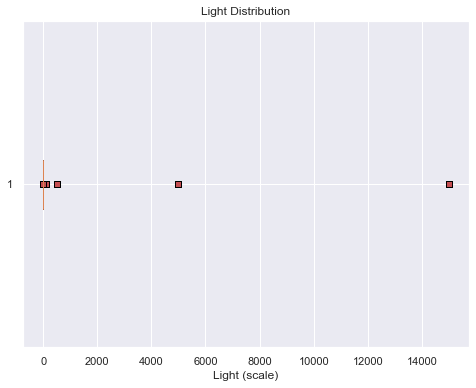

In [699]:
fig1, ax1 = plt.subplots()
fig1.set_size_inches(8, 6, forward=True)
ax1.set_title('Light Distribution')
ax1.set_xlabel('Light (scale)')
ax1.boxplot(light_stats, flierprops=red_square, vert=False, whis=0.75)

### Overall Value Satistics

In [700]:
measurements_count['mean'] = [temp_stats.mean(), light_stats.mean(), humidity_stats.mean(), shock_stats.mean()]
measurements_count['min'] = [temp_stats.min(), light_stats.min(), humidity_stats.min(), shock_stats.min()]
measurements_count['max'] = [temp_stats.max(), light_stats.max(), humidity_stats.max(), shock_stats.max()]
measurements_count['std'] = [temp_stats.std(), light_stats.std(), humidity_stats.std(), shock_stats.std()]

In [701]:
measurements_count

,count,mean,min,max,std
temperature (C),15862535,14.317138,-30.0,80.000000,8.516959
ambient light (scale),2145299,67.939571,0.0,15000.000000,653.375233
humidity (%),1470670,38.561184,1.0,100.000000,18.257025
shock (g),6574,7.934549,0.9,27.655198,5.320642


## Value Statistics by Logger

In [504]:
pivot = loggers_measurements.loc[~loggers_measurements['val'].isnull()][['logger_id', 'sensor', 'val']]


In [505]:
logger_pivot = pd.pivot_table(pivot, values = 'val', index = 'logger_id', columns = 'sensor', aggfunc=np.mean)

In [506]:
logger_pivot['logger_id'] = logger_pivot.index

### Temperature Plot

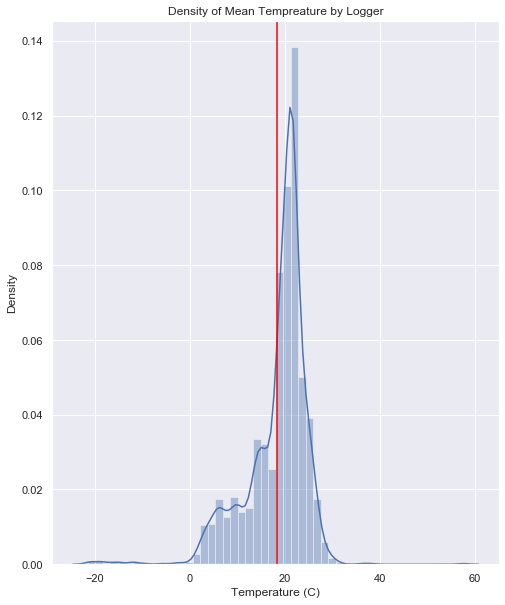

In [507]:
sns.set(rc={'figure.figsize':(8,10)})
temp_den_plot = sns.distplot(logger_pivot[0], kde=True, bins=50)
plt.title('Density of Mean Tempreature by Logger')
temp_den_plot.set(xlabel='Temperature (C)', ylabel='Density')
temp_den_plot.axvline(logger_pivot[0].mean(), color="red")

In [508]:
logger_pivot[0].describe()

count    2100.000000
mean       18.331081
std         6.548482
min       -21.544556
25%        15.822707
50%        20.315994
75%        21.953768
max        57.557112
Name: 0, dtype: float64

### Shock Plot

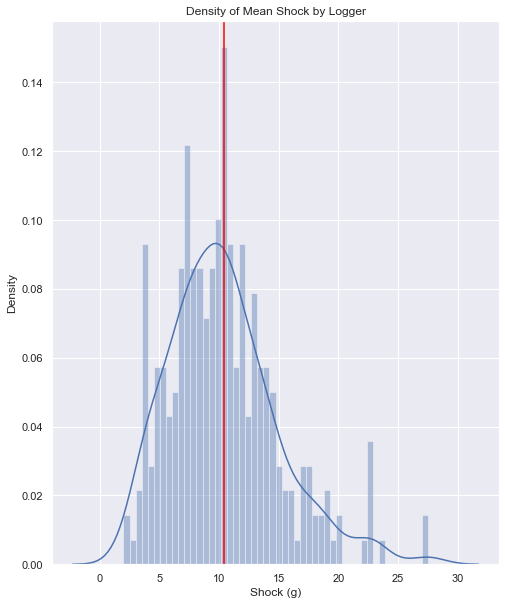

In [510]:
sns.set(rc={'figure.figsize':(8,10)})
shock_den_plot = sns.distplot(logger_pivot[3], kde=True, bins=50)
plt.title('Density of Mean Shock by Logger')
shock_den_plot.set(xlabel='Shock (g)', ylabel='Density')
shock_den_plot.axvline(logger_pivot[3].mean(), color="red")

In [511]:
logger_pivot[3].describe()

count    274.000000
mean      10.382018
std        4.578290
min        2.002498
25%        7.264198
50%       10.010072
75%       12.818215
max       27.482358
Name: 3, dtype: float64

### Humidity Plot

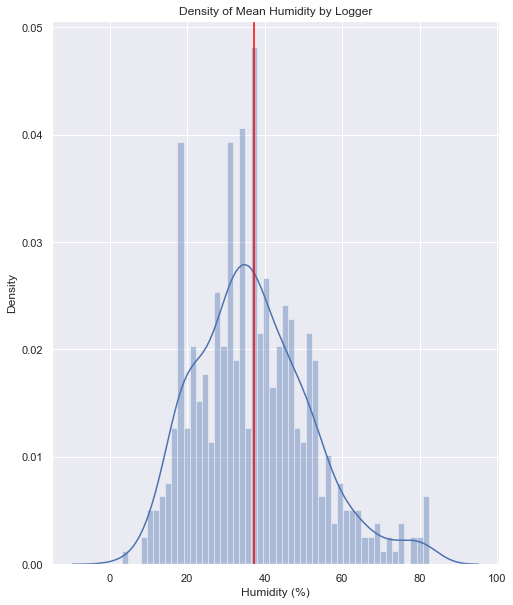

In [512]:
sns.set(rc={'figure.figsize':(8,10)})
hum_den_plot = sns.distplot(logger_pivot[4], kde=True, bins=50)
plt.title('Density of Mean Humidity by Logger')
hum_den_plot.set(xlabel='Humidity (%)', ylabel='Density')
hum_den_plot.axvline(logger_pivot[4].mean(), color="red")

In [513]:
logger_pivot[4].describe()

count    498.000000
mean      37.172017
std       14.792448
min        3.233324
25%       27.169006
50%       36.673071
75%       46.000000
max       82.378395
Name: 4, dtype: float64

### Light Plot

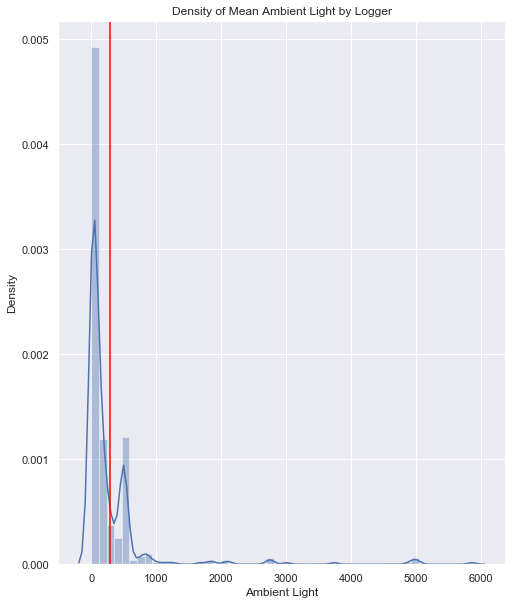

In [514]:
sns.set(rc={'figure.figsize':(8,10)})
light_den_plot = sns.distplot(logger_pivot[5], kde=True, bins=50)
plt.title('Density of Mean Ambient Light by Logger')
light_den_plot.set(xlabel='Ambient Light', ylabel='Density')
light_den_plot.axvline(logger_pivot[5].mean(), color="red")

In [515]:
logger_pivot[5].describe()

count     436.000000
mean      283.669445
std       669.573334
min         0.209460
25%        21.124398
50%        83.223537
75%       300.000000
max      5864.909977
Name: 5, dtype: float64

# Loggers

### Count of Loggers Used by Clients

In [814]:
len(loggers['_id'])

4618

### Logger Count by Model

In [517]:
model_count = loggers['model'].value_counts()
model_count = model_count.to_frame()

In [703]:
model_count

,model
Model 2,2537
Model 3,1402
Model 1,679


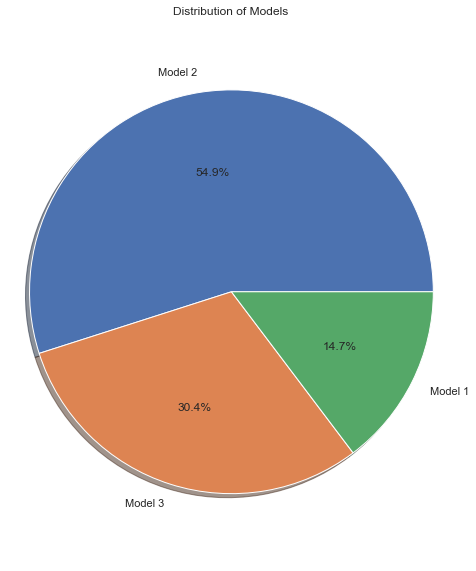

In [702]:
fig1, ax1 = plt.subplots()
ax1.pie(model_count['model'].to_list(), labels=model_count.index.to_list(), autopct='%1.1f%%', shadow=True)
ax1.axis('equal')
ax1.set(title="Distribution of Models")
plt.show()

# Teams & Users

### Loggers by Teams

In [981]:
loggers_teams['team_name'].value_counts()\
[:10].to_frame().style.bar()

,team_name
Suomen Talotekniikka Jyväskylä,286
Fazer Leipomot Oy,166
Loggs Oy,113
Schenker AG – Corporate Head Office,71
Protogen,65
ABB Drives,55
ABB Oy Distribution Solution Vaasa,55
Helsinginktk,46
Budbee,42
Fresh,22


# Scan Events

loggers_scanevents 

### Total Number Measurements Inserted with a Scan 

In [520]:
tot_data = loggers_scanevents['data_count'].describe()

In [521]:
tot_data

count    48499.000000
mean      1820.780758
std       1988.566045
min          1.000000
25%        897.000000
50%       1457.000000
75%       2190.000000
max      18148.000000
Name: data_count, dtype: float64

### Number of New Measurements Inserted with a Scan 

In [522]:
new_data = loggers_scanevents['new_data']
new_data = new_data.dropna().sort_values(ascending = False).describe()

In [704]:
new_data

count    42205.000000
mean       499.591968
std        836.224064
min          1.000000
25%         67.000000
50%        284.000000
75%        587.000000
max      18148.000000
Name: new_data, dtype: float64

### Time Between Two Scans

In [719]:
period_between_two_scans = (loggers_scanevents['created_at']-loggers_scanevents['created_at'].shift()).fillna(pd.Timedelta('0 days'))

In [720]:
period_between_two_scans = period_between_two_scans.sort_values().to_frame().rename(columns = {'created_at':'period'})

In [723]:
period_between_two_scans = period_between_two_scans.loc[period_between_two_scans['period'] > pd.Timedelta('0 days 00:00:01')]

In [724]:
period_between_two_scans.describe()

,period
count,47862
mean,0 days 00:11:40.366117
std,0 days 01:44:15.099758
min,0 days 00:00:01.002000
25%,0 days 00:00:20.488500
50%,0 days 00:01:14.510500
75%,0 days 00:04:43.281250
max,6 days 01:52:18.837000


### Teams with Most Scans

In [15]:
team_scans = loggers_teams_scanevents['team_name'].value_counts()[:10].to_frame()\
                        .rename(columns = {'team_name':'scans'})

In [14]:
loggers_teams_scanevents['team_name'].value_counts()

Fazer Leipomot Oy                                        8635
Budbee                                                   7921
Loggs Oy                                                 1995
Neveres dosis                                            1815
Suomen Talotekniikka Jyväskylä                           1632
Apteekit                                                 1355
ABB Oy Distribution Solution Vaasa                        746
Helsinginktk                                              723
MagnumMedical                                             465
NiGK                                                      446
Luvianapteekki                                            403
Hoivatiimi                                                370
Biotrans-usa                                              345
ABB Drives                                                345
HUS LOGISTIIKKA 2019                                      331
Lawtons                                                   274
Protogen

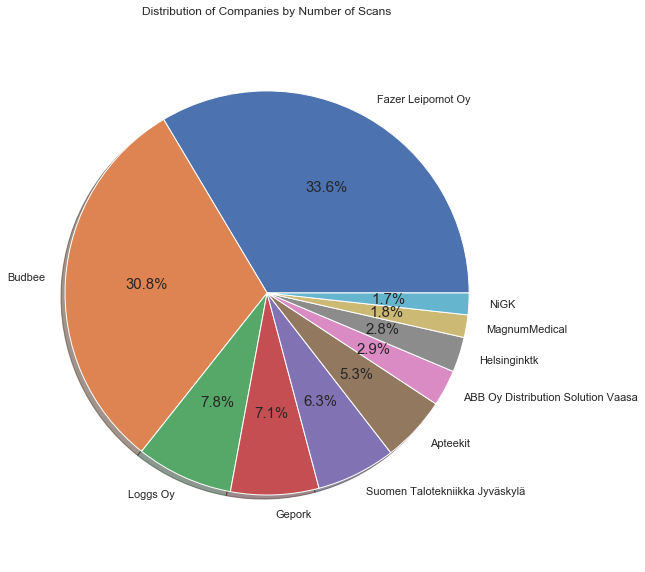

In [983]:
fig1, ax1 = plt.subplots()
ax1.pie(team_scans['scans'].to_list(), labels=team_scans.index.to_list(), autopct='%1.1f%%', shadow=True)
ax1.axis('equal')
ax1.set(title="Distribution of Companies by Number of Scans")
plt.show()

### Time Between Two Scans by 5 Teams from Different Industries

#### Fazer Leipomot Oy

In [528]:
fazer = loggers_teams_scanevents.loc[loggers_teams_scanevents['team_name'] == 'Fazer Leipomot Oy']\
        .sort_values(by = ['scanned_at'])

In [529]:
fazer_scanning = (fazer['scanned_at']-fazer['scanned_at'].shift()).fillna(pd.Timedelta('0 days'))

##### How Frequently Fazer Leipomot Oy Scans One of Its Loggers

In [730]:
fazer_period = fazer_scanning.sort_values().to_frame().rename(columns = {'scanned_at':'period'})

In [732]:
fazer_period = fazer_period.loc[fazer_period['period'] > pd.Timedelta('0 days 00:00:01')]

In [734]:
fazer_period.describe()

,period
count,8569
mean,0 days 00:53:26.336897
std,0 days 05:17:19.090114
min,0 days 00:00:01.053000
25%,0 days 00:01:52.830000
50%,0 days 00:06:12.733000
75%,0 days 00:15:52.974000
max,13 days 02:52:19.932000


##### How frequently Fazer Leipomot Oy Scans Its Most Scanned Logger

In [531]:
f_best_logger_id = fazer['logger_id'].value_counts().index[0]
f_best_logger = fazer.loc[fazer['logger_id'] == f_best_logger_id]
f_best_logger_scanning = (f_best_logger['scanned_at']-f_best_logger['scanned_at'].shift()).fillna(pd.Timedelta('0 days'))

In [532]:
limit = pd.Timedelta('0 days 00:05:00')

In [533]:
f_best_logger_scanning = f_best_logger_scanning.to_frame().rename(columns = {'scanned_at':'period'})

In [534]:
f_best_logger_scanning.loc[f_best_logger_scanning['period'] >= limit].describe()

,period
count,279
mean,0 days 15:37:38.190670
std,0 days 19:06:22.872290
min,0 days 00:05:25.667000
25%,0 days 01:57:23.700000
50%,0 days 03:05:27.840000
75%,0 days 22:04:18.784500
max,7 days 20:00:43.514000


#### BudBee

In [535]:
budbee = loggers_teams_scanevents.loc[loggers_teams_scanevents['team_name'] == 'Budbee']\
        .sort_values(by = ['scanned_at'])


In [536]:
budbee_scanning = (budbee['scanned_at']-budbee['scanned_at'].shift()).fillna(pd.Timedelta('0 days'))


##### How Frequently Budbee Scans One of Its Loggers

In [745]:
budbee_period = budbee_scanning.to_frame().rename(columns = {'scanned_at':'period'})

In [746]:
budbee_period = budbee_period.loc[budbee_period['period'] > pd.Timedelta('0 days 00:00:01')]

In [747]:
budbee_period.describe()

,period
count,7836
mean,0 days 00:19:48.783476
std,0 days 03:14:44.461531
min,0 days 00:00:01.014000
25%,0 days 00:00:25.017500
50%,0 days 00:01:20.982000
75%,0 days 00:03:56.857000
max,4 days 17:23:31.630000


##### How frequently Budbee Scans Its Most Scanned Logger

In [538]:
b_best_logger_id = budbee['logger_id'].value_counts().index[0]
b_best_logger = budbee.loc[budbee['logger_id'] == b_best_logger_id]
b_best_logger_scanning = (b_best_logger['scanned_at']-b_best_logger['scanned_at'].shift()).fillna(pd.Timedelta('0 days'))

In [539]:
b_best_logger_scanning = b_best_logger_scanning.to_frame().rename(columns = {'scanned_at':'period'})

In [540]:
b_best_logger_scanning.loc[b_best_logger_scanning['period'] >= limit].describe()

,period
count,279
mean,0 days 09:00:31.300157
std,0 days 18:57:22.068860
min,0 days 00:05:02.581000
25%,0 days 00:46:15.912000
50%,0 days 01:58:39.585000
75%,0 days 06:35:11.869500
max,5 days 20:05:48.287000


### ABB

In [541]:
abb = loggers_teams_scanevents.loc[loggers_teams_scanevents['team_name'].str.contains('ABB')].sort_values(by = ['scanned_at'])

In [542]:
abb_scanning = (abb['scanned_at']-abb['scanned_at'].shift()).fillna(pd.Timedelta('0 days'))

##### How Frequently ABB Scans One of Its Loggers

In [739]:
abb_period = abb_scanning.to_frame().rename(columns = {'scanned_at':'period'})

In [749]:
abb_period = abb_period.loc[abb_period['period'] > pd.Timedelta('0 days 00:00:01')]

In [750]:
abb_period.describe()

,period
count,1074
mean,0 days 06:15:08.967295
std,0 days 23:16:08.226840
min,0 days 00:00:01.050000
25%,0 days 00:00:17.881000
50%,0 days 00:01:17.797000
75%,0 days 00:35:20.583000
max,16 days 01:12:51.210000


##### How frequently ABB Scans Its Most Scanned Logger

In [544]:
a_best_logger_id = abb['logger_id'].value_counts().index[0]
a_best_logger = abb.loc[abb['logger_id'] == a_best_logger_id]
a_best_logger_scanning = (a_best_logger['scanned_at']-a_best_logger['scanned_at'].shift()).fillna(pd.Timedelta('0 days'))

In [545]:
a_best_logger_scanning = a_best_logger_scanning.to_frame().rename(columns = {'scanned_at':'period'})

In [546]:
a_best_logger_scanning.loc[a_best_logger_scanning['period'] >= limit].describe()

,period
count,33
mean,7 days 05:06:42.643848
std,7 days 23:48:58.775830
min,0 days 00:07:10.453000
25%,1 days 00:07:32.573000
50%,3 days 21:22:43.532000
75%,12 days 19:33:53.532000
max,35 days 23:24:35.873000


### MagnumMedical

In [547]:
magnum = loggers_teams_scanevents.loc[loggers_teams_scanevents['team_name'] =='MagnumMedical'].sort_values(by = ['scanned_at'])

In [548]:
magnum_scanning = (magnum['scanned_at']-magnum['scanned_at'].shift()).fillna(pd.Timedelta('0 days'))

##### How Frequently MagnumMedical Scans One of Its Loggers

In [751]:
magnum_period = magnum_scanning.to_frame().rename(columns = {'scanned_at':'period'})

In [752]:
magnum_period = magnum_period.loc[magnum_period['period'] > pd.Timedelta('0 days 00:00:01')]

In [753]:
magnum_period.describe()

,period
count,463
mean,0 days 09:10:16.726900
std,0 days 19:29:48.687247
min,0 days 00:00:04.166000
25%,0 days 00:01:02.061000
50%,0 days 00:50:17.160000
75%,0 days 06:09:38.328500
max,6 days 01:06:46.653000


##### How frequently MagnumMedica Scans Its Most Scanned Logger

In [550]:
m_best_logger_id = magnum['logger_id'].value_counts().index[0]
m_best_logger = magnum.loc[magnum['logger_id'] == m_best_logger_id]
m_best_logger_scanning = (m_best_logger['scanned_at']-m_best_logger['scanned_at'].shift()).fillna(pd.Timedelta('0 days'))

In [551]:
m_best_logger_scanning = m_best_logger_scanning.to_frame().rename(columns = {'scanned_at':'period'})

In [552]:
m_best_logger_scanning.loc[m_best_logger_scanning['period'] >= limit].describe()

,period
count,41
mean,4 days 01:12:12.039146
std,4 days 08:48:45.188493
min,0 days 01:46:15.252000
25%,0 days 19:56:06.126000
50%,1 days 23:46:49.863000
75%,7 days 00:10:53.409000
max,17 days 22:38:20.255000


### Schenker AG – Corporate Head Office

In [553]:
schenker = loggers_teams_scanevents.loc[loggers_teams_scanevents['team_name'] =='Schenker AG – Corporate Head Office'].sort_values(by = ['scanned_at'])

In [554]:
schenker_scanning = (schenker['scanned_at']-schenker['scanned_at'].shift()).fillna(pd.Timedelta('0 days'))

##### How Frequently Schenker AG Scans One of Its Loggers

In [754]:
schenker_period = schenker_scanning.to_frame().rename(columns = {'scanned_at':'period'})

In [755]:
schenker_period = schenker_period.loc[schenker_period['period'] > pd.Timedelta('0 days 00:00:01')]

In [756]:
schenker_period.describe()

,period
count,237
mean,0 days 19:50:52.707907
std,2 days 11:14:08.497389
min,0 days 00:00:03.662000
25%,0 days 00:00:22.008000
50%,0 days 00:03:57.834000
75%,0 days 03:19:36.362000
max,23 days 19:57:00.939000


##### How frequently Schenker AG Scans Its Most Scanned Logger

In [556]:
s_best_logger_id = schenker['logger_id'].value_counts().index[0]
s_best_logger = schenker.loc[schenker['logger_id'] == s_best_logger_id]
s_best_logger_scanning = (s_best_logger['scanned_at']-s_best_logger['scanned_at'].shift()).fillna(pd.Timedelta('0 days'))

In [557]:
s_best_logger_scanning = s_best_logger_scanning.to_frame().rename(columns = {'scanned_at':'period'})

In [558]:
s_best_logger_scanning.loc[s_best_logger_scanning['period'] >= limit].describe()

,period
count,22
mean,5 days 14:06:01.076136
std,9 days 23:00:46.627301
min,0 days 00:06:18.241000
25%,0 days 00:34:48.798500
50%,2 days 22:57:58.713000
75%,7 days 00:20:47.780000
max,46 days 03:34:50.930000


# Missions

## Missions by Teams

In [984]:
missions_teams = loggers_missions_teams['team_name'].value_counts()

In [985]:
missions_teams.to_frame().style.bar()

,team_name
MagnumMedical,322
Hoivatiimi,185
Fredman Perfect Kitchen Oy,106
Fresh,100
Pielaveden Apteekki,74
Gepork,64
Apteekit,51
MAP Medical Technologies Oy,44
Budbee,34
Medifon,27


## Mission Duration Statistics

In [645]:
mission_durations = loggers_missions.drop_duplicates(subset = 'mission_id')

In [647]:
mission_durations['mission_duration_in_hours'].describe()

count    1139.000000
mean      221.979969
std       444.398766
min         0.166983
25%        16.956967
50%       143.349579
75%       263.471179
max      5207.799252
Name: mission_duration_in_hours, dtype: float64

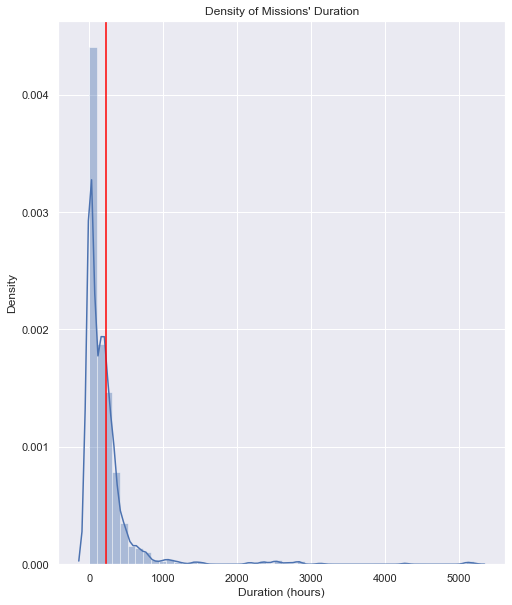

In [759]:
sns.set(rc={'figure.figsize':(8,10)})
missions_den_plot = sns.distplot(mission_durations['mission_duration_in_hours'], kde=True, bins=50)
plt.title("Density of Missions' Duration")
missions_den_plot.set(xlabel='Duration (hours)', ylabel='Density')
missions_den_plot.axvline(mission_durations['mission_duration_in_hours'].mean(), color="red")

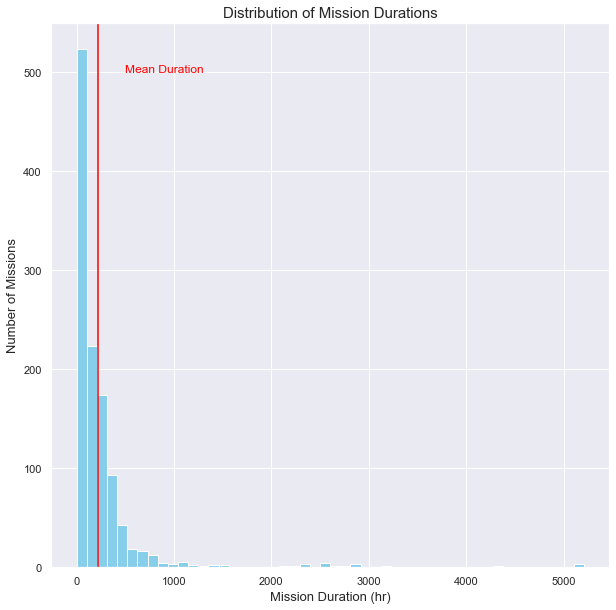

In [844]:
fig, ax = plt.subplots(figsize=(10,10))
ax.hist(mission_durations['mission_duration_in_hours'], bins=50, color="skyblue");
ax.set_xlabel("Mission Duration (hr)", fontsize=13) 
ax.set_ylabel("Number of Missions", fontsize=13);
ax.axvline(mission_durations['mission_duration_in_hours'].mean(), color="red");
ax.text(x=500,y=500, s="Mean Duration", color="red");
ax.set_title('Distribution of Mission Durations', fontsize = 15);

In [864]:
no_outliers = mission_durations['mission_duration_in_hours'].to_frame()
no_outliers = no_outliers.loc[(no_outliers['mission_duration_in_hours'] <= 504) & (no_outliers['mission_duration_in_hours'] >= 1)]

In [870]:
no_outliers.describe()

,mission_duration_in_hours
count,890.000000
mean,157.927047
std,129.321682
min,1.008889
25%,24.294465
50%,163.124594
75%,240.985233
max,503.844474


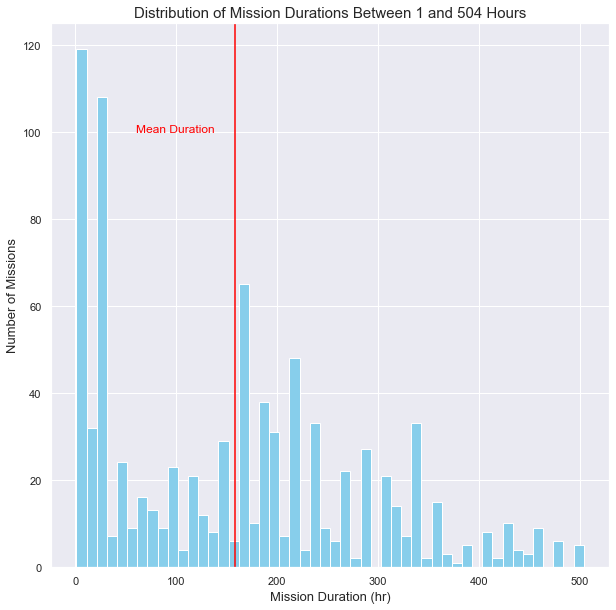

In [869]:
fig, ax = plt.subplots(figsize=(10,10))
ax.hist(no_outliers['mission_duration_in_hours'], bins=50, color="skyblue");
ax.set_xlabel("Mission Duration (hr)", fontsize=13) 
ax.set_ylabel("Number of Missions", fontsize=13);
ax.axvline(no_outliers['mission_duration_in_hours'].mean(), color="red");
ax.text(x=60,y=100, s="Mean Duration", color="red");
ax.set_title('Distribution of Mission Durations Between 1 and 504 Hours', fontsize = 15);

# Alert Rules

## Temperature Limits

In [892]:
temp_limit_gt = loggers_alerthits_alertrules.loc[(loggers_alerthits_alertrules['sensor'] == 0) & ((loggers_alerthits_alertrules['method'] == 'gt') |\
                                                (loggers_alerthits_alertrules['method'] == 'gte'))]

In [908]:
temp_limit_gt['limit'].describe()

count    314788.000000
mean         12.411942
std           6.823712
min         -15.000000
25%           7.000000
50%           8.000000
75%          20.000000
max          40.000000
Name: limit, dtype: float64

In [897]:
temp_limit_lt = loggers_alerthits_alertrules.loc[(loggers_alerthits_alertrules['sensor'] == 0) & ((loggers_alerthits_alertrules['method'] == 'lt') |\
                                                (loggers_alerthits_alertrules['method'] == 'lte'))]

In [911]:
temp_limit_lt['limit'].describe()

count    135841.000000
mean         13.261137
std           5.656913
min         -20.000000
25%          15.600000
50%          16.000000
75%          16.000000
max          25.000000
Name: limit, dtype: float64

## Shock Limits

In [926]:
shock_limit_gt = loggers_alerthits_alertrules.loc[(loggers_alerthits_alertrules['sensor'] == 3) & ((loggers_alerthits_alertrules['method'] == 'gt') |\
                                                (loggers_alerthits_alertrules['method'] == 'gte'))]

In [927]:
shock_limit_gt['limit'].describe()

count    81.000000
mean      6.012346
std       1.145577
min       5.000000
25%       5.000000
50%       5.000000
75%       7.000000
max      10.000000
Name: limit, dtype: float64

In [903]:
shock_limit_lt = loggers_alerthits_alertrules.loc[(loggers_alerthits_alertrules['sensor'] == 3) & ((loggers_alerthits_alertrules['method'] == 'lt') |\
                                                (loggers_alerthits_alertrules['method'] == 'lte'))]

In [906]:
shock_limit_lt['limit'].describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: limit, dtype: float64

## Humidity Limits

In [928]:
humidity_limit_gt = loggers_alerthits_alertrules.loc[(loggers_alerthits_alertrules['sensor'] == 4) & ((loggers_alerthits_alertrules['method'] == 'gt') |\
                                                (loggers_alerthits_alertrules['method'] == 'gte'))]

In [929]:
humidity_limit_gt['limit'].describe()

count    1604.000000
mean       33.509975
std         9.668196
min        30.000000
25%        30.000000
50%        30.000000
75%        30.000000
max        65.000000
Name: limit, dtype: float64

In [930]:
humidity_limit_lt = loggers_alerthits_alertrules.loc[(loggers_alerthits_alertrules['sensor'] == 4) & ((loggers_alerthits_alertrules['method'] == 'lt') |\
                                                (loggers_alerthits_alertrules['method'] == 'lte'))]

In [931]:
humidity_limit_lt['limit'].describe()

count    12245.000000
mean        24.279298
std          8.202381
min         20.000000
25%         20.000000
50%         20.000000
75%         20.000000
max         40.000000
Name: limit, dtype: float64

## Light Limits

In [932]:
light_limit_gt = loggers_alerthits_alertrules.loc[(loggers_alerthits_alertrules['sensor'] == 5) & ((loggers_alerthits_alertrules['method'] == 'gt') |\
                                                (loggers_alerthits_alertrules['method'] == 'gte'))]

In [933]:
light_limit_gt['limit'].describe()

count    2926.000000
mean        0.000684
std         0.036974
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         2.000000
Name: limit, dtype: float64

In [934]:
light_limit_lt = loggers_alerthits_alertrules.loc[(loggers_alerthits_alertrules['sensor'] == 5) & ((loggers_alerthits_alertrules['method'] == 'lt') |\
                                                (loggers_alerthits_alertrules['method'] == 'lte'))]

In [935]:
light_limit_lt['limit'].describe()

count    561.0
mean      20.0
std        0.0
min       20.0
25%       20.0
50%       20.0
75%       20.0
max       20.0
Name: limit, dtype: float64

# Alert Hits

## Number of Violations 

In [888]:
len(loggers_alerthits)

479247

In [991]:
alert_distribution = loggers_alerthits['sensor'].value_counts().to_frame()\

In [992]:
alert_distribution.index = ['temperature', 'humidity', 'light', 'shock']

In [993]:
alert_distribution

,sensor
temperature,461823
humidity,13849
light,3487
shock,88


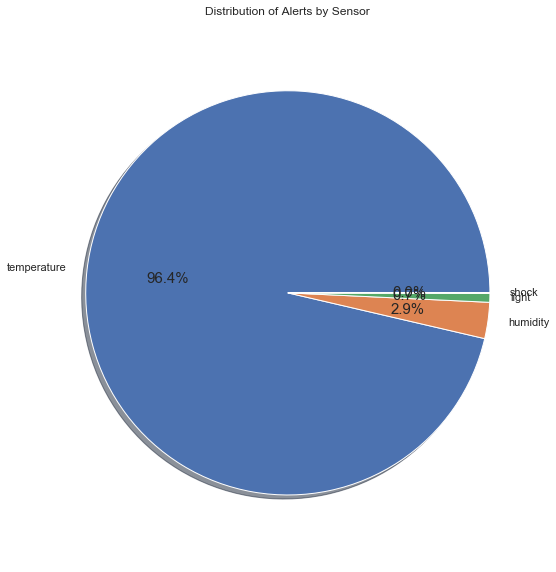

In [995]:
fig1, ax1 = plt.subplots()
ax1.pie(alert_distribution['sensor'].to_list(), labels=alert_distribution.index.to_list(), autopct='%1.1f%%', shadow=True)
ax1.axis('equal')
ax1.set(title="Distribution of Alerts by Sensor")
plt.show()

## Alert Violations by Sensor

### Temperature

In [559]:
temp_violation = loggers_alerthits.loc[loggers_alerthits['sensor'] == 0]['violation']

In [560]:
temp_violation.describe()

count    461747.000000
mean          5.144020
std           7.937743
min         -39.000000
25%          -0.800000
50%           4.400000
75%          12.800000
max          41.000000
Name: violation, dtype: float64

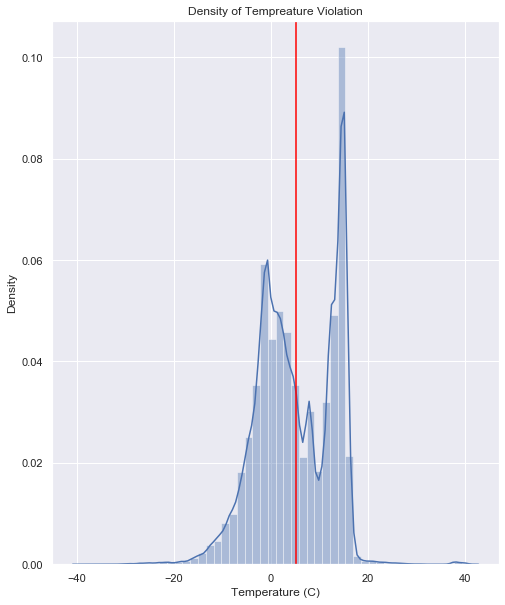

In [582]:
sns.set(rc={'figure.figsize':(8,10)})
temp_violation_den_plot = sns.distplot(temp_violation, kde=True, bins=50)
plt.title('Density of Tempreature Violation')
temp_violation_den_plot.set(xlabel='Temperature (C)', ylabel='Density')
temp_violation_den_plot.axvline(temp_violation.mean(), color="red")

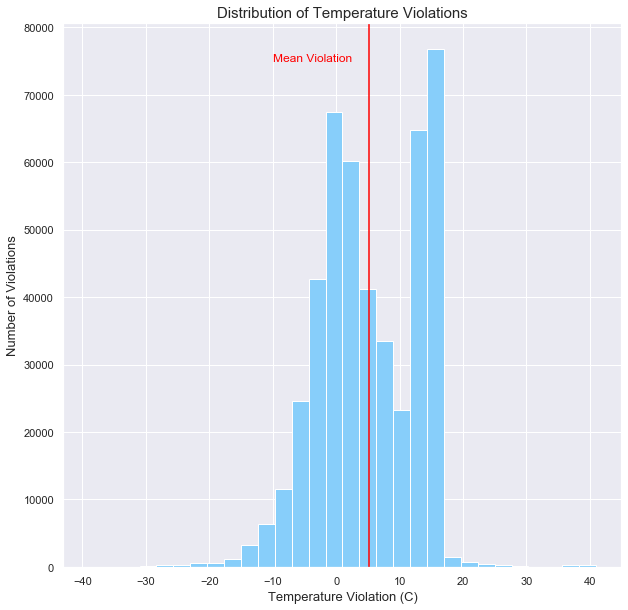

In [798]:
fig, ax = plt.subplots(figsize=(10,10))
ax.hist(temp_violation, bins=30, color="lightskyblue");
ax.set_xlabel("Temperature Violation (C)", fontsize=13) 
ax.set_ylabel("Number of Violations", fontsize=13);
ax.axvline(temp_violation.mean(), color="red");
ax.text(x=-10,y=75000, s="Mean Violation", color="red");
ax.set_title('Distribution of Temperature Violations', fontsize = 15);

### Shock

In [563]:
shock_violation = loggers_alerthits.loc[loggers_alerthits['sensor'] == 3]['violation']

In [564]:
shock_violation.describe()

count    88.00000
mean     11.19125
std       7.72108
min       0.15000
25%       4.06750
50%      10.27000
75%      19.46750
max      22.66000
Name: violation, dtype: float64

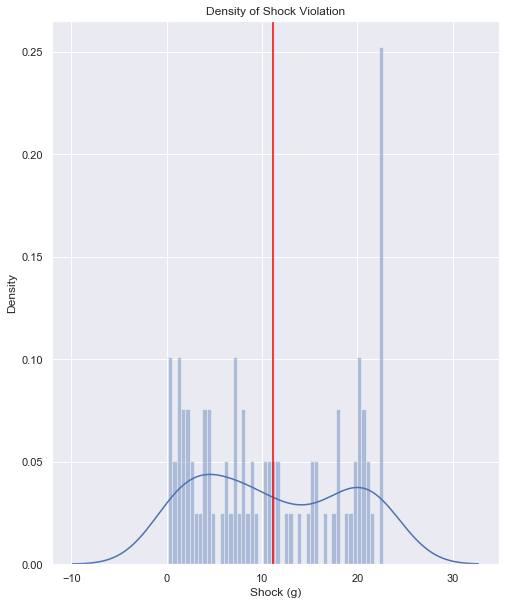

In [583]:
sns.set(rc={'figure.figsize':(8,10)})
shock_violation_den_plot = sns.distplot(shock_violation, kde=True, bins=50)
plt.title('Density of Shock Violation')
shock_violation_den_plot.set(xlabel='Shock (g)', ylabel='Density')
shock_violation_den_plot.axvline(shock_violation.mean(), color="red")

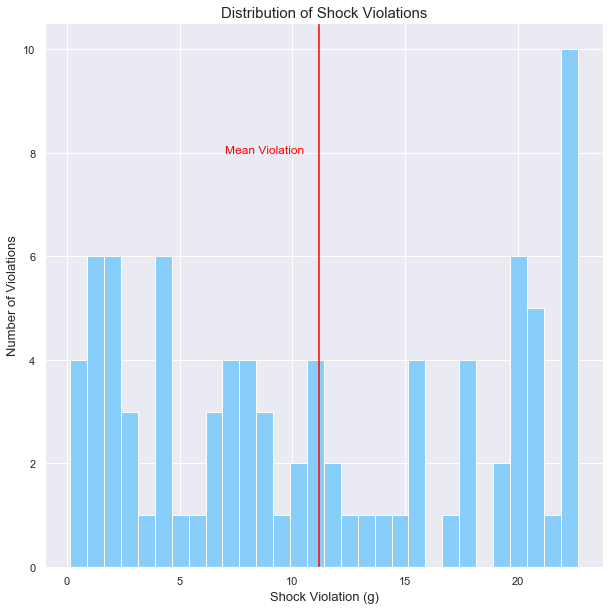

In [783]:
fig, ax = plt.subplots(figsize=(10,10))
ax.hist(shock_violation, bins=30, color="lightskyblue");
ax.set_xlabel("Shock Violation (g)", fontsize=13) 
ax.set_ylabel("Number of Violations", fontsize=13);
ax.axvline(shock_violation.mean(), color="red");
ax.text(x=7,y=8, s="Mean Violation", color="red");
ax.set_title('Distribution of Shock Violations', fontsize = 15);

### Humidity

In [566]:
hum_violation = loggers_alerthits.loc[loggers_alerthits['sensor'] == 4]['violation']

In [567]:
hum_violation.describe()

count    13849.00000
mean        -2.15113
std          8.84215
min        -19.00000
25%         -7.00000
50%         -4.00000
75%         -1.00000
max         70.00000
Name: violation, dtype: float64

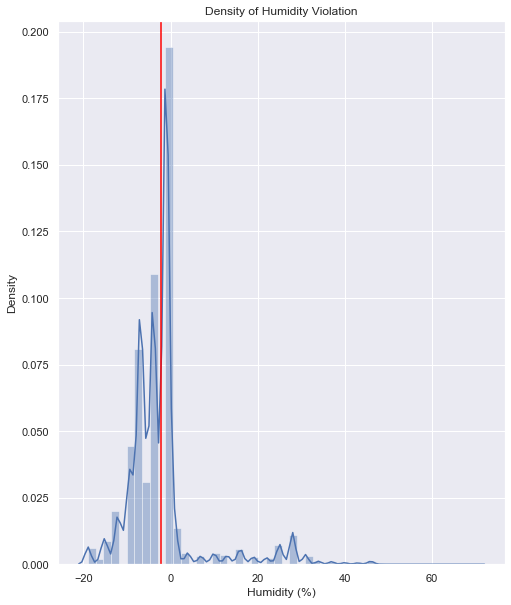

In [584]:
sns.set(rc={'figure.figsize':(8,10)})
hum_violation_den_plot = sns.distplot(hum_violation, kde=True, bins= 50)
plt.title('Density of Humidity Violation')
hum_violation_den_plot.set(xlabel='Humidity (%)', ylabel='Density')
hum_violation_den_plot.axvline(hum_violation.mean(), color="red")

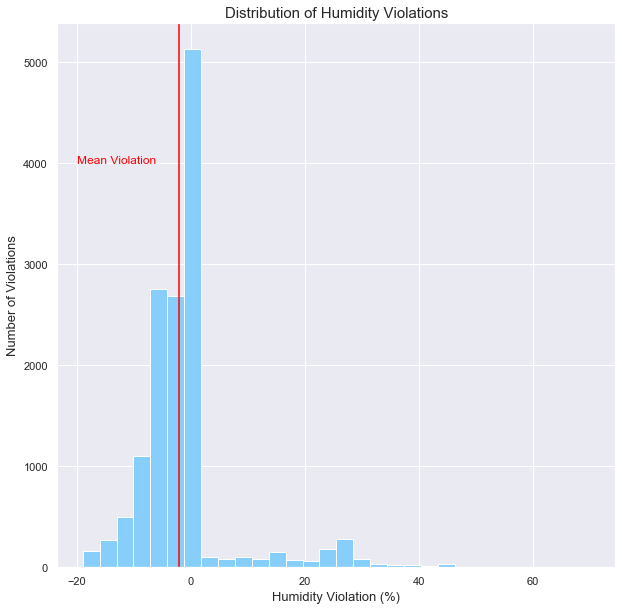

In [801]:
fig, ax = plt.subplots(figsize=(10,10))
ax.hist(hum_violation, bins=30, color="lightskyblue");
ax.set_xlabel("Humidity Violation (%)", fontsize=13) 
ax.set_ylabel("Number of Violations", fontsize=13);
ax.axvline(hum_violation.mean(), color="red");
ax.text(x=-20,y=4000, s="Mean Violation", color="red");
ax.set_title('Distribution of Humidity Violations', fontsize = 15);

### Light

In [568]:
light_violation = loggers_alerthits.loc[loggers_alerthits['sensor'] == 5]['violation']

In [569]:
light_violation.describe()

count    3487.000000
mean       -1.237167
std        13.545517
min       -20.000000
25%         1.000000
50%         1.000000
75%         1.000000
max       498.000000
Name: violation, dtype: float64

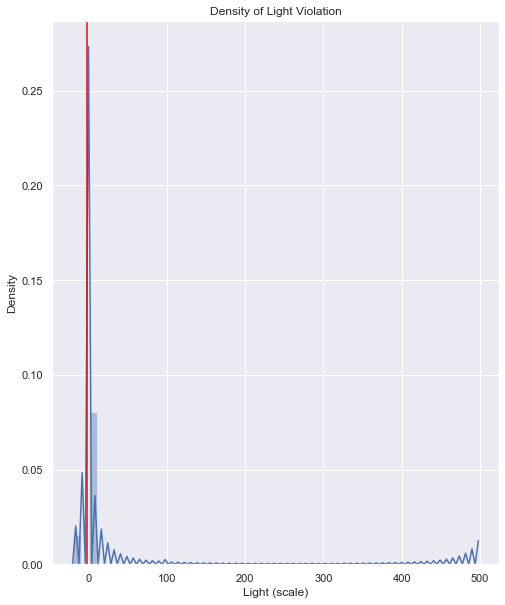

In [586]:
sns.set(rc={'figure.figsize':(8,10)})
light_violation_den_plot = sns.distplot(light_violation, kde=True, bins=50)
plt.title('Density of Light Violation')
light_violation_den_plot.set(xlabel='Light (scale)', ylabel='Density')
light_violation_den_plot.axvline(light_violation.mean(), color="red")

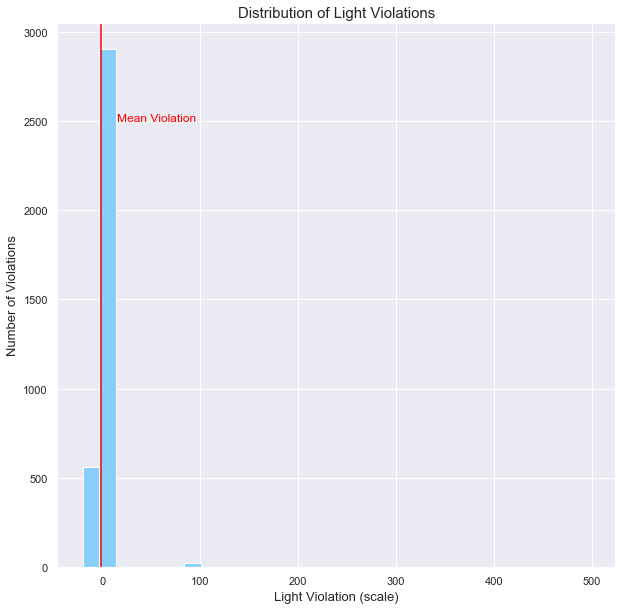

In [805]:
fig, ax = plt.subplots(figsize=(10,10))
ax.hist(light_violation, bins=30, color="lightskyblue");
ax.set_xlabel("Light Violation (scale)", fontsize=13) 
ax.set_ylabel("Number of Violations", fontsize=13);
ax.axvline(light_violation.mean(), color="red");
ax.text(x=15,y=2500, s="Mean Violation", color="red");
ax.set_title('Distribution of Light Violations', fontsize = 15);

## Alert violation by Logger

In [587]:
alert_pivot_data = loggers_alerthits.loc[~loggers_alerthits['violation'].isnull()]

In [588]:
alert_pivot = pd.pivot_table(alert_pivot_data, values = 'violation', index = 'logger_id', columns = 'sensor', aggfunc=np.mean)